# Module 6 Lab 3 - Support Vector Machine to predict readmission

In this lab, we will attempt to predict readmissions using a support vector machine, and compare the results to previous methods.

Support Vector Machines are another black box AI approach to binary classification.  SVM's work by finding a plane separating two groups of data with the distance from the plane to the closest data from each category.  For two dimensional data it is easy to represent this visually.

<img src='../resources/svm_separating_hyperplanes.png'>


Hyperplane H3 (which is simply a line for the two dimensional case) does not separate the classes, whereas H1 and H2 do; however, H2 is the support vector because it maximally separates the two classes (largest distances between closest point in each class).

When the data are not linearly separable, then a function can be applied to create a third dimension that allows the data to be linearly separable.  This is the kernel function.

Support Vector Machines can support a large number of features; however, the more features, the longer the model fitting takes.  

SVM's can be used for classification problems such as the one in this lab.  They have also been applied to image classification problems as well, because they can handle a large amount of features, such as you find in an image.



In [1]:
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline

## Apply transformations to our data
These are the same transformations as applied to the logistic regression model.  See Lab 1 for more explanations.

In [3]:
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('../resources/diabetes_readmission.csv')
display(data.head())

y = data['readmitted']
X = data[['discharge', 'age', 'race', 'admission_type', 'specialty', 'time_in_hospital', 'diag_1', 'A1Cresult', 'change']].copy()

scaler = StandardScaler()
X['time_in_hospital'] = scaler.fit_transform(X[['time_in_hospital']])

# create dummy variables
X = pd.concat([X, pd.get_dummies(X['age'], prefix = 'age', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['race'], prefix = 'race', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['admission_type'], prefix = 'admission_type', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['specialty'], prefix = 'specialty', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['diag_1'], prefix = 'diag_1', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['A1Cresult'], prefix = 'A1Cresult', drop_first=True)], axis=1)

# drop originals
X = X.drop(['age', 'race', 'admission_type', 'specialty', 'diag_1', 'A1Cresult'], axis=1)

# balance the classes
display(y.value_counts())

X_oversampled, y_oversampled = resample(X[y == 1], y[y == 1], replace=True, n_samples=X[y == 0].shape[0], random_state=42)

X = pd.DataFrame(np.vstack((X[y == 0], X_oversampled)), columns=X.columns)
y = np.hstack((y[y == 0], y_oversampled))

display(pd.Series(y).value_counts())

,readmitted,discharge,age,race,admission_type,specialty,time_in_hospital,diag_1,A1Cresult,change
0,1,0,0,1,1,0,8,8,0,1
1,0,0,0,1,1,4,2,8,0,0
2,0,1,2,1,1,2,4,8,2,0
3,0,0,2,1,1,2,3,8,3,1
4,0,0,0,0,1,2,5,8,0,0


0    60145
1     5813
Name: readmitted, dtype: int64

1    60145
0    60145
dtype: int64

## Train the Support Vector Machine

This process will fit the data to a set of support vectors.  We use the [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) class from scikit learn, which handles created a classification model using SVM.

Be warned that this training process will take a long time (possibly several hours or more).  Because we wish to score the probabilities, and this feature is not a native result of building an SVM, an expensive computation estimation is done.

In [4]:
from sklearn import svm
from sklearn.model_selection import train_test_split

# train/test split, specify the seed for reproducible results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


model = svm.SVC(kernel='rbf', probability=True, verbose=True, random_state=42).fit(X_train, y_train)



[LibSVM]

## Visualize and compare the results

accuracy 0.598851269649335


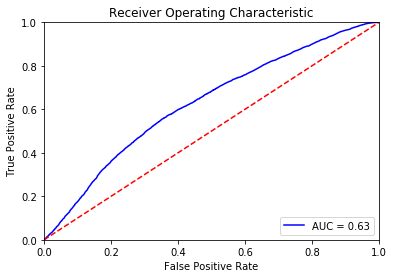

confusion matrix:
[[12247  7702]
 [ 8222 11525]]

classification report:
              precision    recall  f1-score   support

           0       0.60      0.61      0.61     19949
           1       0.60      0.58      0.59     19747

    accuracy                           0.60     39696
   macro avg       0.60      0.60      0.60     39696
weighted avg       0.60      0.60      0.60     39696



In [5]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

print('accuracy', model.score(X_test, y_test))

probs = model.predict_proba(X_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_pred = model.predict(X_test)

cmatrix = confusion_matrix(y_test, y_pred)
print('confusion matrix:')
print(cmatrix)
print('\nclassification report:')
print(classification_report(y_test, y_pred))

## Results
Both the ROC and Accuracy are slightly better than logistic regression, but worse than decision trees and random forest, by a large margin.  For this particular problem, SVM is not suitable, as the performance is close to that of regression, but the resulting model is less interpretable, and the training takes quite a bit longer.

